# Separación de las imágenes y preparación del dataset final

## Librerías

In [28]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from PIL import Image as Im
import numpy as np
import shutil

## Lectura de los datos

In [5]:
# directorio datos:

data_directory = Path.cwd() / 'spatial_data'
rgb_filename = 'merged_raster_preprocessed.png'
mask_filename = 'badajoz_multiclass_mask.png'
rgb_path = data_directory / rgb_filename
mask_path = data_directory / mask_filename

In [6]:
# Lectura de imagen RGB con open cv

rgb_image = cv2.imread(rgb_path, 1) # El flag 1 indica que la imagen se lea como RGB

In [7]:
# Para leer la imagen multimáscara, es preferible utilizar pillow

Im.MAX_IMAGE_PIXELS = None # Eliminar la protección contra ataques decompression bomb DOS
mask_image = Im.open(mask_path)
mask_image_np = np.array(mask_image) # Transformar a array de numpy

## Obtención de cuadrados

### Imagen RGB

In [8]:
square_size = 512

In [9]:
height, width, _ = rgb_image.shape

In [10]:
# Crear una carpeta para guardar las imágenes
os.makedirs('dataset/raw/features', exist_ok=True)

# Dividir la imagen en pequeños cuadrados
for y in range(0, height, square_size):
    for x in range(0, width, square_size):
        # Obtener el bloque de la imagen
        block = rgb_image[y:y+square_size, x:x+square_size]
        
        # Guardar el bloque
        block_filename = f'dataset/raw/features/square_{x}_{y}.png'
        cv2.imwrite(block_filename, block)

### Máscara

In [11]:
height, width = mask_image_np.shape

In [12]:
# Crear una carpeta para guardar las imáscaras
os.makedirs('dataset/raw/labels', exist_ok=True)

# Dividir la máscara en pequeños cuadrados
for y in range(0, height, square_size):
    for x in range(0, width, square_size):
        # Obtener el bloque de la máscara
        block = mask_image_np[y:y+square_size, x:x+square_size]
        
        # Guardar el bloque
        block_filename = f'dataset/raw/labels/mask_{x}_{y}.png'
        cv2.imwrite(block_filename, block)

Vamos a comprobar que las máscaras son correctas, ya que al guardarlas como escala de grises, son indistingibles al ojo humano.

Vemos que los valores de la máscara están comprendidos entre 0 y 5

## Limpieza de datos

### Eliminación de imágenes y máscaras rectangulares

En primer lugar, vamos a eliminar las imágenes que no tengan la resolución necesaria. Estas se corresponden a los límites sur y este de badajoz y se debe a que el tamaño de las nuevas imágenes (500 p) no es múltiplo del ancho o del largo de la imagen original.

In [13]:
print(f'resolución original: {rgb_image.shape[:-1]} píxeles')

resolución original: (17281, 23085) píxeles


In [14]:
# Directorio de imágenes y máscaras

images_path = Path.cwd() / 'dataset/raw/features'
masks_path = Path.cwd() / 'dataset/raw/labels'

image_files_list = list(images_path.glob('*.png'))
mask_files_list = list(masks_path.glob('*.png'))

print(f'nº imágenes: {len(image_files_list)}\nnº máscaras: {len(mask_files_list)}')

nº imágenes: 1564
nº máscaras: 1564


Para optimizar la búsqueda, vamos a utilizar los nombres de las imágenes, ya que tienen información del área de la imagen original a la que pertenecen.

In [15]:
# Obtener parámetros de la imagen original
X_PX, Y_PX = rgb_image.shape[:-1]

In [16]:
to_drop_dict = {'Image':[],'Mask':[]}

for image, mask in zip(image_files_list, mask_files_list):
    
    # Obtengo el fichero con image.parts[-1], me quedo con el nombre sin la extensión .png y separo por _ para obtener los metadatos
    y, x = image.parts[-1].split(sep='.')[0].split(sep='_')[1:]

    # Obtengo los márgenes horizontales y verticales de cada imagen

    x_margin = X_PX - int(x)
    y_margin = Y_PX - int(y)

    # Si el margen es menor al tamaño del cuadrado, entonces se trata de un rectángulo de lado menor a 500

    if (x_margin < square_size) | (y_margin < square_size):

        to_drop_dict['Image'].append(image)
        to_drop_dict['Mask'].append(mask)

In [17]:
def to_drop_update(feats, labels, dict):
    '''Actualización de las listas de elementos válidos a partir del diccionario de elementos a eliminar'''

    keys = list(dict.keys())
    drop_images = dict[keys[0]]
    drop_labels = dict[keys[1]]

    valid_feats = list()
    valid_labels = list()

    for image, mask in zip(feats, labels):

        if not(image in drop_images) and not(mask in drop_labels):
            valid_feats.append(image)
            valid_labels.append(mask)

    return (valid_feats, valid_labels)

In [18]:
valid_images, valid_masks = to_drop_update(image_files_list, mask_files_list, to_drop_dict)

### Eliminación de máscaras de valor nulo

Las imagenes que no tienen ningún tipo de uso no tendrán ninguna utilidad.

In [19]:
to_drop_dict = {'Image':[],'Mask':[]}

for image, mask in zip(valid_images, valid_masks):

    mask_image = np.array(Im.open(mask))

    if not(mask_image.max()):

        to_drop_dict['Image'].append(image)
        to_drop_dict['Mask'].append(mask)

In [20]:
valid_images, valid_masks = to_drop_update(valid_images, valid_masks, to_drop_dict)

### Eliminación de máscaras para balanceo de clases

Si se va a utilizar un modelo de segmentación, las imágenes que no contengan píxeles solares ni de invernadero introducirán un enorme desbalanceo.

In [21]:
id_solar = 1 # Etiqueta que representa pixel solar
id_grhouse = 2 # Etiqueta que representa pixel de invernadero
for_segmentation = True # Flag para indicar si el dataset servirá para entrenar un modelo de segmentación

In [22]:
if for_segmentation:
    
    to_drop_dict = {'Image':[],'Mask':[]}

    for image, mask in zip(valid_images, valid_masks):

        mask_image = np.array(Im.open(mask))

        if (not id_solar in mask_image) and (not id_grhouse in mask_image):

            to_drop_dict['Image'].append(image)
            to_drop_dict['Mask'].append(mask)

In [23]:
if for_segmentation:
    valid_images, valid_masks = to_drop_update(valid_images, valid_masks, to_drop_dict)

Ya tenemos el diccionario con las imágenes y máscaras que no vamos a utilizar. Vamos a copiar y pegar todos los archivos que necesitamos a una carpeta.

In [24]:
# Directorios de destino

clean_images_path = Path.cwd() / 'dataset/clean/features'
clean_masks_path = Path.cwd() / 'dataset/clean/labels'

In [25]:
# Creación de directorios

os.makedirs(clean_images_path, exist_ok=True)
os.makedirs(clean_masks_path, exist_ok=True)

In [26]:
for image, mask in zip(valid_images, valid_masks):
    shutil.copy(image,clean_images_path)
    shutil.copy(mask,clean_masks_path)

### Verificación

A continuación, se verifica visualmente la correspondencia imagen-máscara de los nuevos recuadros.

In [29]:
IMAGE_DIR = Path.cwd().joinpath('dataset/clean/features')
MASK_DIR = Path.cwd().joinpath('dataset/clean/labels')

base = list(IMAGE_DIR.glob('*.png'))
mask = list(MASK_DIR.glob('*.png'))

def compare_img(ind):
    array_base = np.array(Im.open(base[ind]).convert("RGB"))
    array_mask = np.array(Im.open(mask[ind]))

    # Crear una copia de la imagen para superponer la matriz
    imagen_superpuesta = array_base.copy()

    # Crear una máscara para los píxeles solares
    mascara = array_mask == 1

    # Aplicar color amarillo a los píxeles solares
    imagen_superpuesta[mascara] = [255, 255, 0]

    # Mostrar la imagen original y la imagen superpuesta
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(array_base)
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')

    axes[1].imshow(imagen_superpuesta)
    axes[1].set_title("Imagen con Superposición")
    axes[1].axis('off')

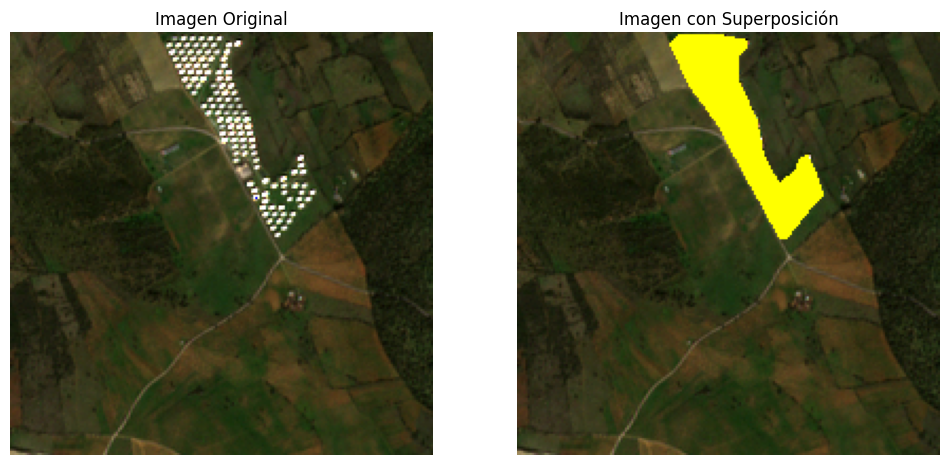

In [33]:
ind = np.random.randint(0, len(base))
compare_img(ind)